In [ ]:
!pip install einops

In [ ]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

from ml_tutorial import PositionalEncoding, FeedForwardBlock, MultiHeadAttentionBlock
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torch.optim as optim
import math
import torch.nn.functional as F
import numpy as np

Dataset Setting Referenced from [DeepFindr](https://www.youtube.com/@DeepFindr)

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


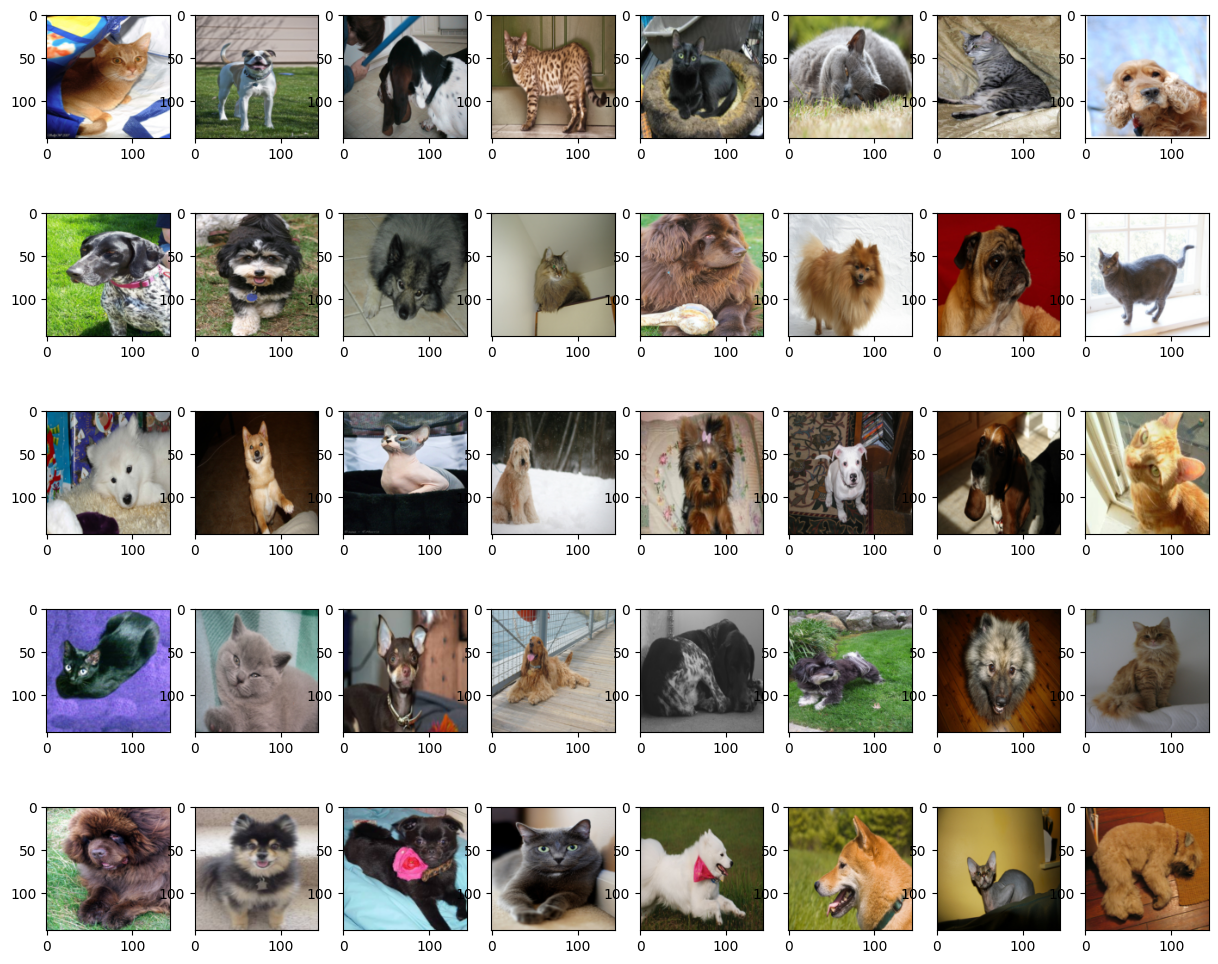

In [ ]:
to_tensor = [Resize((144, 144)), ToTensor()] # Each image in the dataset is resized to 144x144 pixels. -> Batch Normalization!

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

In [ ]:
# PatchEmbedding class is used to convert an image into a sequence of flattened patches,
# which can then be fed into a transformer model. The image is divided into smaller patches,
# each patch is flattened, and then projected into an embedding space.
# This embedding serves as the input to the transformer, allowing it to process image data.

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # Break the image into (patch_size x patch_size) patches and flatten them
            # Input shape: (batch_size, in_channels, height, width)
            # Output shape: (batch_size, number_of_patches, patch_size*patch_size*in_channels)
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # Linear projection from flattened patch size to embedding size
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)  # Apply the projection to get patch embeddings
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)  # size[1] = number of patches (sequence length), size[2] = embedding dimension

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [ ]:
class Residual(nn.Module):
    def __init__(self, dropout: float, d_model: int) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.BatchNorm1d(d_model)  # Batch normalization across the feature dimension

    def forward(self, x, sublayer):
        # BatchNorm1d expects input of shape (batch_size, num_features, seq_length)
        x = x.transpose(1, 2)  # Transpose to (batch_size, d_model, seq_length) for BatchNorm1d
        x = self.norm(x)  # Apply batch normalization
        x = x.transpose(1, 2)  # Transpose back to (batch_size, seq_length, d_model)
        return x + self.dropout(sublayer(x))  # Add residual connection with dropout

class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float, d_model: int) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block  # Multi-head self-attention mechanism
        self.feed_forward_block = feed_forward_block  # Feedforward network
        self.residual_connections = nn.ModuleList([Residual(dropout, d_model) for _ in range(2)])  # Two residual connections with batch normalization and dropout

    def forward(self, x, src_mask):
        # Apply self-attention with residual connection
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        # Apply feedforward network with residual connection
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [ ]:
# Encoder class for processing image data in a transformer-based model.
# The Encoder first embeds the input image into patch embeddings and adds positional encodings to incorporate spatial information.
# It then passes the encoded patches through a series of EncoderBlocks, each consisting of a multi-head self-attention mechanism
# and a feedforward network, both with residual connections that include batch normalization and dropout.
# Finally, batch normalization is applied to stabilize the output before returning the processed feature representations.

class Encoder(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, depth, n_heads, dropout) -> None:
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)  # Convert image to patch embeddings
        self.pos_embed = PositionalEncoding(embed_dim, (img_size // patch_size) ** 2, dropout)  # Add positional encodings
        self.layers = nn.ModuleList([
            EncoderBlock(
                MultiHeadAttentionBlock(embed_dim, n_heads, dropout),
                FeedForwardBlock(embed_dim, embed_dim * 4, dropout),
                dropout,
                embed_dim  # Pass d_model to EncoderBlock
            ) for _ in range(depth)
        ])  # Stack multiple EncoderBlocks
        self.norm = nn.BatchNorm1d(embed_dim)  # Apply batch normalization to the final output

    def forward(self, x, mask=None):
        x = self.patch_embed(x)  # Apply patch embedding
        x = self.pos_embed(x)  # Add positional encodings
        for layer in self.layers:
            x = layer(x, mask)  # Pass through each EncoderBlock
        x = x.transpose(1, 2)  # Prepare for batch normalization by transposing
        x = self.norm(x)  # Apply batch normalization
        x = x.transpose(1, 2)  # Transpose back to original shape
        return x  # Return the processed output

In [ ]:
# Split the dataset into training and testing sets with an 80/20 ratio.
# `train_split` determines the number of samples in the training set.
# The remainder of the dataset is used for testing.

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

# Create DataLoaders for the training and testing sets.
# The training DataLoader shuffles the data for each epoch to improve generalization.
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
# The testing DataLoader also shuffles the data, though this is less common for testing, it's useful if you want random batches.
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
# ViTClassifier is a Vision Transformer (ViT) based classifier.
# The model consists of an encoder, which processes the input image patches,
# followed by a classifier that performs global average pooling and linear classification.

class ViTClassifier(nn.Module):
    def __init__(self, encoder, embed_dim, num_classes):
        super(ViTClassifier, self).__init__()
        self.encoder = encoder  # Transformer encoder for feature extraction
        self.classifier = nn.Linear(embed_dim, num_classes)  # Linear layer for classification

    def forward(self, x):
        x = self.encoder(x)  # Pass input through the encoder
        x = x.mean(dim=1)  # Apply global average pooling to obtain a fixed-size vector
        x = self.classifier(x)  # Classify the pooled features
        return x

# Define the image and model parameters
img_size = 144
patch_size = 4
in_channels = 3
embed_dim = 32
depth = 2
n_heads = 2
dropout = 0.1

# Initialize the encoder with the specified parameters
encoder = Encoder(img_size, patch_size, in_channels, embed_dim, depth, n_heads, dropout)

# Set up the device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up the model, optimizer, and loss function
num_classes = 37  # Number of classes in the OxfordIIITPet dataset
model = ViTClassifier(encoder, embed_dim, num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # AdamW optimizer for stable training
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Training and evaluation loop
for epoch in range(50):
    epoch_losses = []
    model.train()  # Set the model to training mode
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        epoch_losses.append(loss.item())

    # Periodically evaluate the model on the test set
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for evaluation
            for step, (inputs, labels) in enumerate(test_dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  3.603503281655519
>>> Epoch 0 test loss:  3.5861306916112485
>>> Epoch 5 train loss:  3.186968427637349
>>> Epoch 5 test loss:  3.324128596679024
>>> Epoch 10 train loss:  2.9907403795615486
>>> Epoch 10 test loss:  3.1233723992886753
>>> Epoch 15 train loss:  2.8533344087393386
>>> Epoch 15 test loss:  3.202052759087604
>>> Epoch 20 train loss:  2.718298834303151
>>> Epoch 20 test loss:  2.9866038405376933
>>> Epoch 25 train loss:  2.5650250108345696
>>> Epoch 25 test loss:  2.866110138271166
>>> Epoch 30 train loss:  2.4560588274313058
>>> Epoch 30 test loss:  2.9371155759562617
>>> Epoch 35 train loss:  2.3739983530148216
>>> Epoch 35 test loss:  2.920635223388672
>>> Epoch 40 train loss:  2.2750199061373007
>>> Epoch 40 test loss:  2.863166270048722
>>> Epoch 45 train loss:  2.1895165054694465
>>> Epoch 45 test loss:  2.9139577824136484


Predicted vs Actual classes:
Image 1: Predicted: Boxer, Actual: British Shorthair


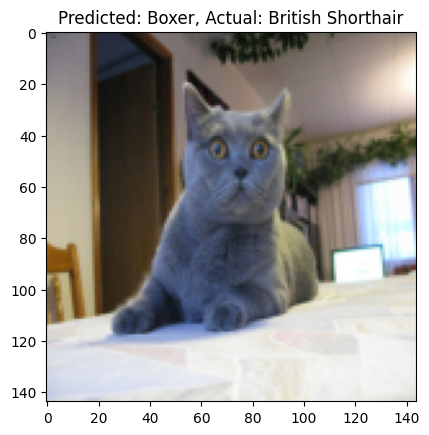

Image 2: Predicted: Chihuahua, Actual: Keeshond


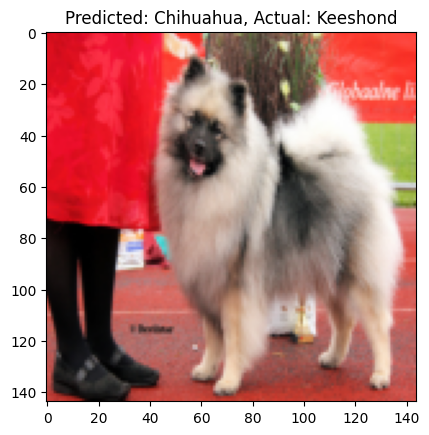

Image 3: Predicted: Keeshond, Actual: Staffordshire Bull Terrier


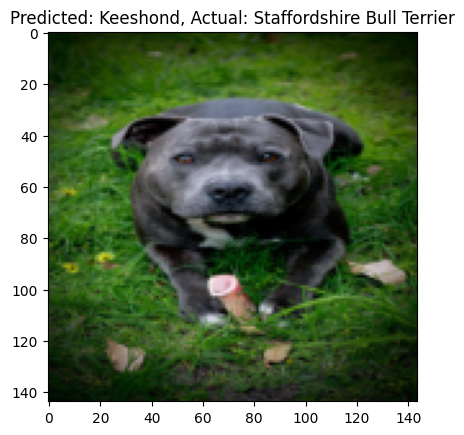

Image 4: Predicted: American Pit Bull Terrier, Actual: Havanese


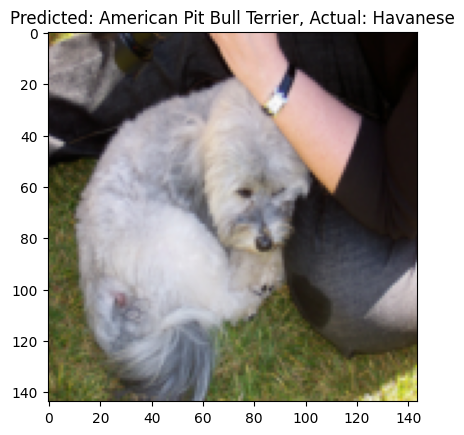

Image 5: Predicted: Egyptian Mau, Actual: Egyptian Mau


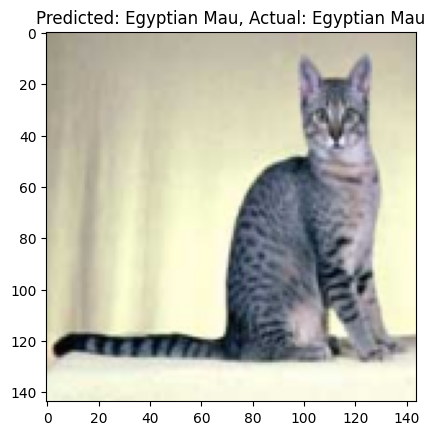

Image 6: Predicted: Persian, Actual: Maine Coon


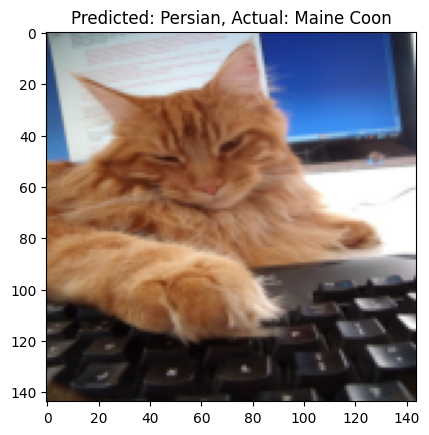

Image 7: Predicted: Japanese Chin, Actual: Beagle


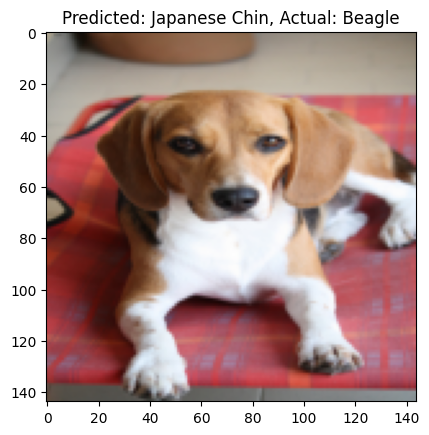

Image 8: Predicted: Persian, Actual: English Cocker Spaniel


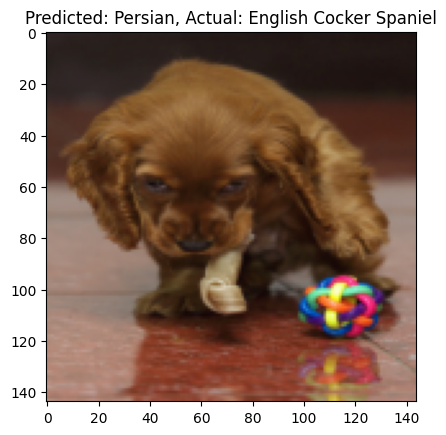

Image 9: Predicted: Birman, Actual: Siamese


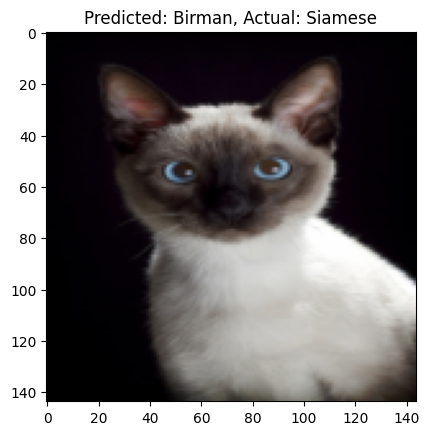

Image 10: Predicted: Leonberger, Actual: Pug


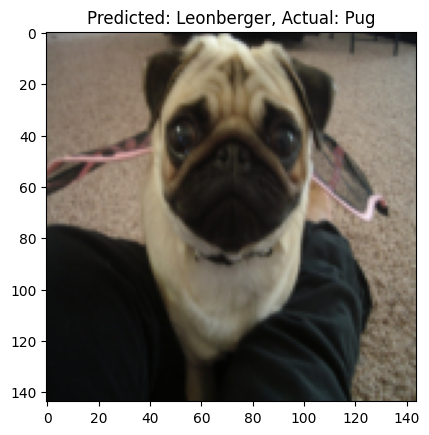

Image 11: Predicted: Yorkshire Terrier, Actual: Yorkshire Terrier


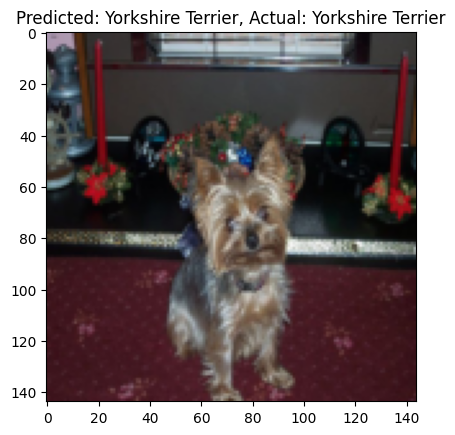

Image 12: Predicted: Chihuahua, Actual: Siamese


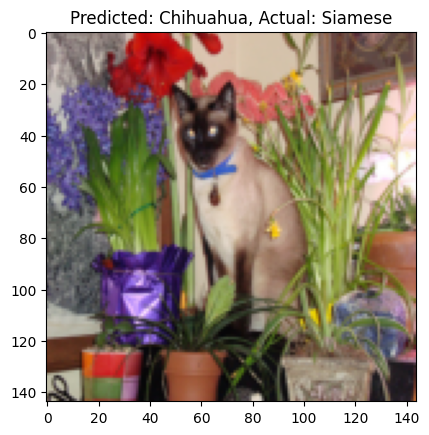

Image 13: Predicted: British Shorthair, Actual: Russian Blue


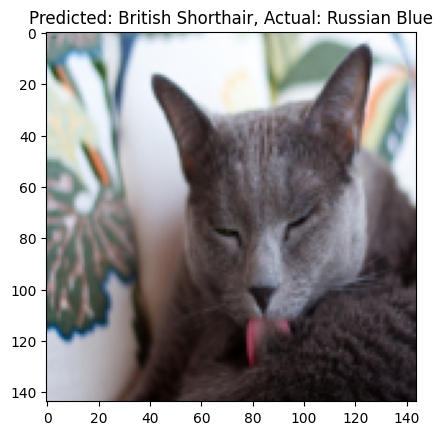

Image 14: Predicted: Samoyed, Actual: Persian


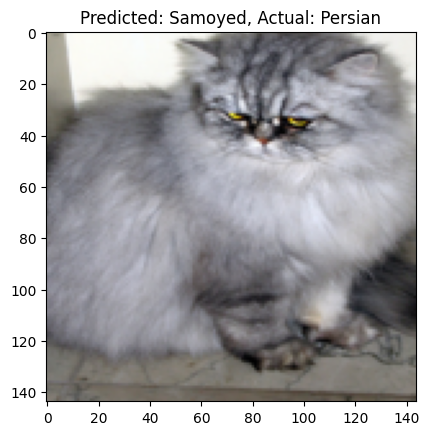

Image 15: Predicted: Newfoundland, Actual: Newfoundland


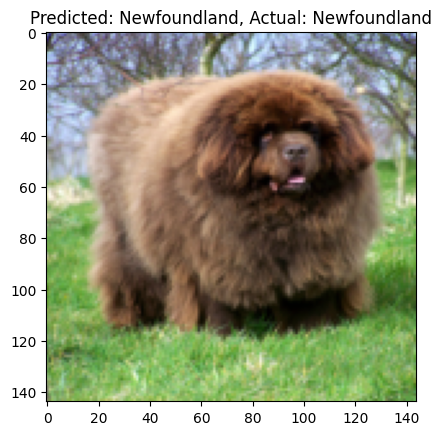

Image 16: Predicted: Miniature Pinscher, Actual: Staffordshire Bull Terrier


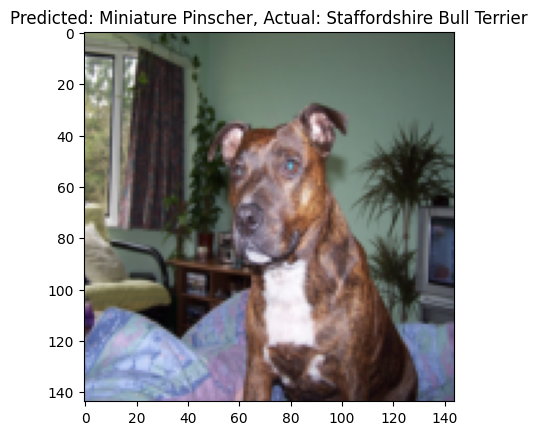

Image 17: Predicted: English Cocker Spaniel, Actual: Bengal


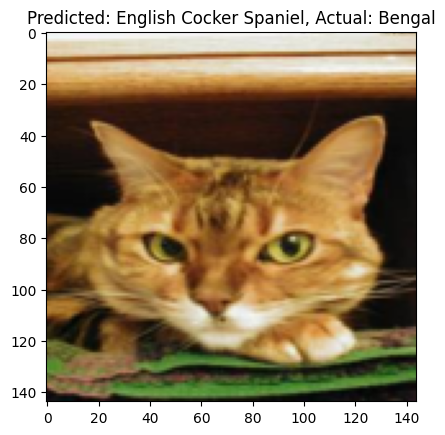

Image 18: Predicted: Keeshond, Actual: Staffordshire Bull Terrier


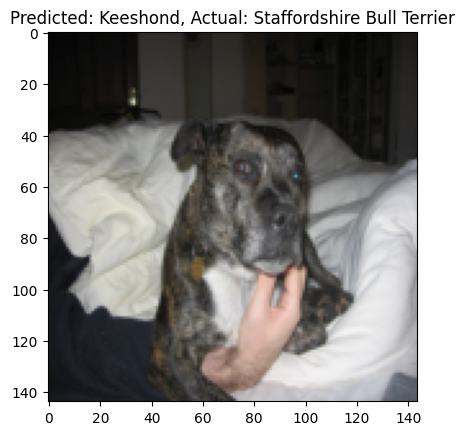

Image 19: Predicted: Samoyed, Actual: Samoyed


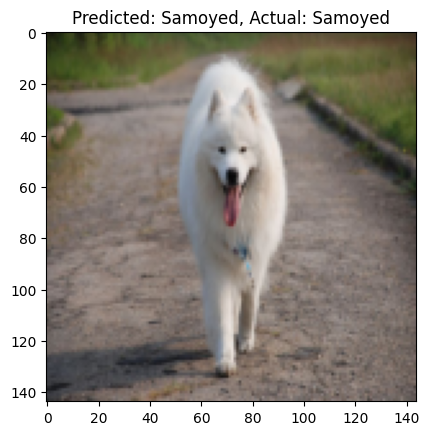

Image 20: Predicted: Maine Coon, Actual: Maine Coon


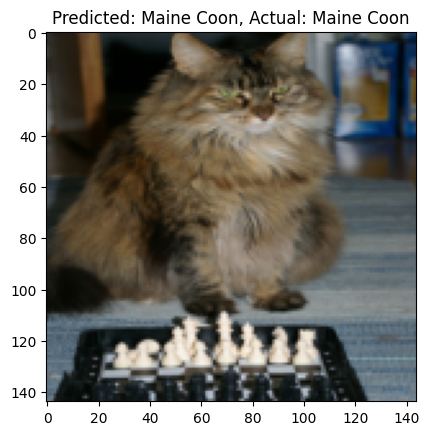

Image 21: Predicted: Samoyed, Actual: Siamese


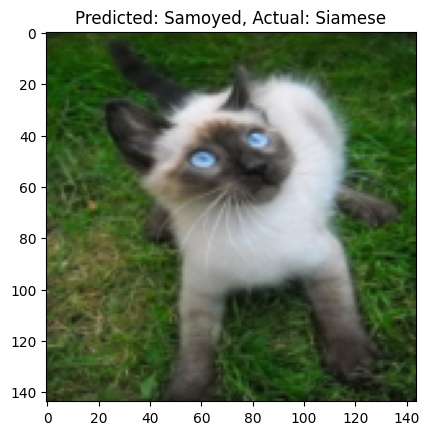

Image 22: Predicted: Leonberger, Actual: British Shorthair


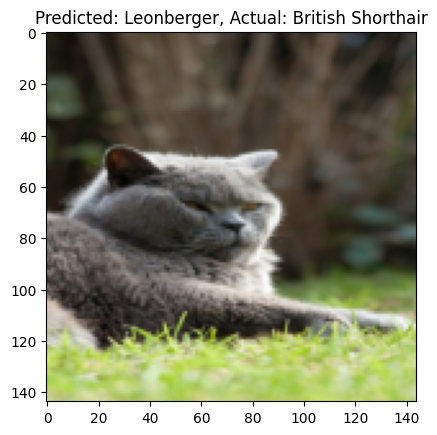

Image 23: Predicted: Basset Hound, Actual: Basset Hound


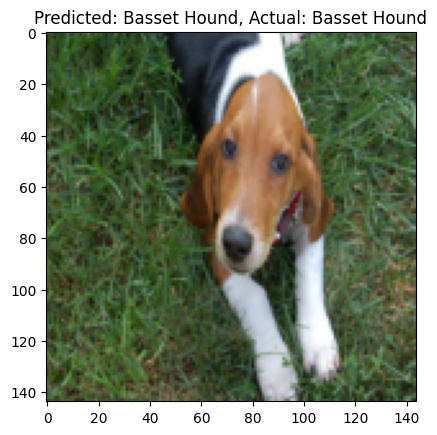

Image 24: Predicted: Great Pyrenees, Actual: Great Pyrenees


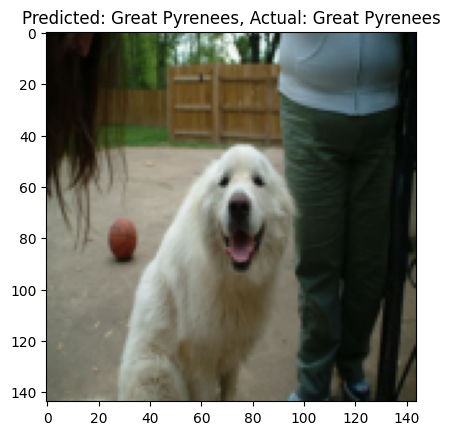

Image 25: Predicted: Keeshond, Actual: Russian Blue


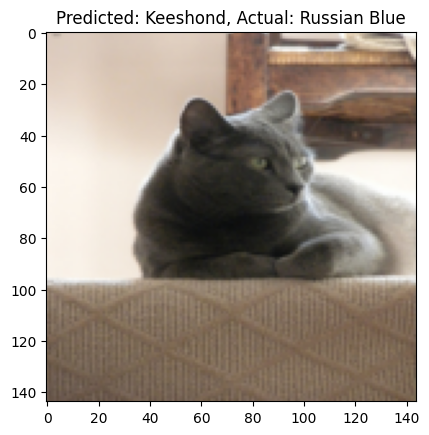

Image 26: Predicted: English Setter, Actual: Bengal


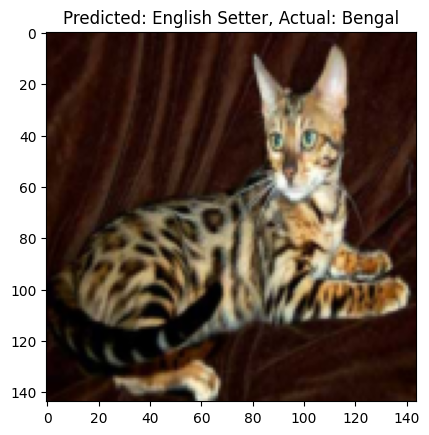

Image 27: Predicted: Shiba Inu, Actual: Beagle


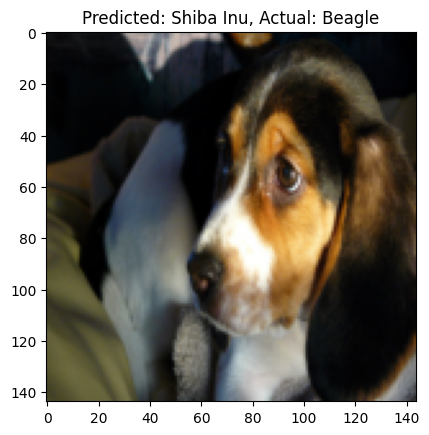

Image 28: Predicted: Bombay, Actual: Newfoundland


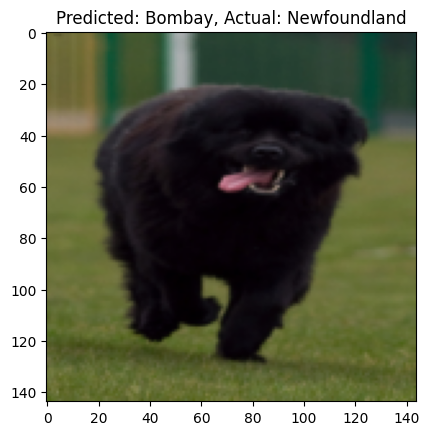

Image 29: Predicted: Beagle, Actual: Shiba Inu


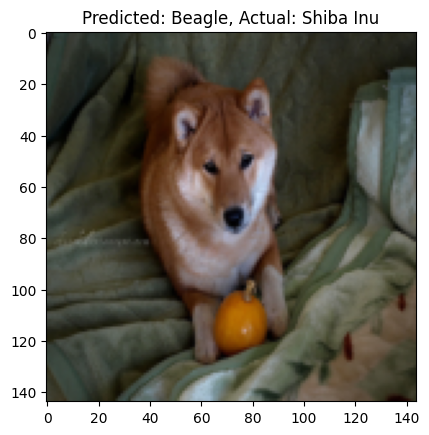

Image 30: Predicted: Wheaten Terrier, Actual: Shiba Inu


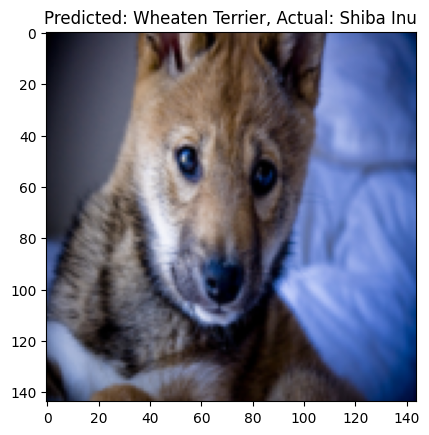

Image 31: Predicted: Newfoundland, Actual: American Pit Bull Terrier


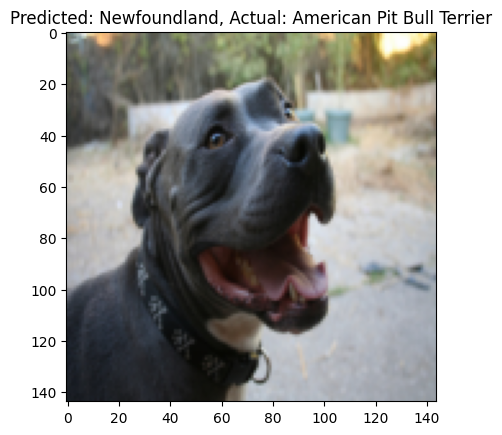

Image 32: Predicted: Saint Bernard, Actual: Boxer


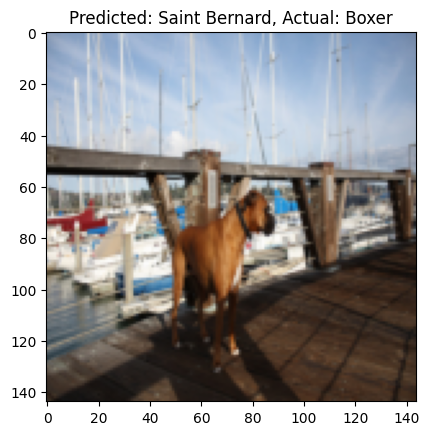

In [ ]:
# fetch class_names from the dataset
class_names = dataset.classes

# Get a batch of inputs and labels from the test dataloader
inputs, labels = next(iter(test_dataloader))
# Move the inputs and labels to the specified device (e.g., GPU or CPU)
inputs, labels = inputs.to(device), labels.to(device)
# Pass the inputs through the model to get the outputs
outputs = model(inputs)

# get predicted classes and actual classes
predicted_classes = outputs.argmax(-1).tolist()
actual_classes = labels.tolist()

# compare and visualize
print("Predicted vs Actual classes:")
for i, (input_tensor, pred, actual) in enumerate(zip(inputs, predicted_classes, actual_classes)):
    predicted_class_name = class_names[pred]
    actual_class_name = class_names[actual]
    print(f"Image {i + 1}: Predicted: {predicted_class_name}, Actual: {actual_class_name}")

    # convert tensor to image
    img = to_pil_image(input_tensor.cpu())

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}, Actual: {actual_class_name}")
    plt.show()